## Renewed attempt at Decoding Rules
Current state of notebook:
- Determined that splitting by trial probably isn't the best idea, since using a BlockSplitter would mean the test set has the same label across
- What if we split by block to decode? 
  - Each block would be data point, don't need to worry about capturing time correlation since next block is randomly (?) chosen. 
  - Can average neural activity across trials to get mean firing rates for per neuron within block
  - Train/Test split on blocks
  

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 300
post_interval = 500

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = behavioral_utils.exclude_first_block(valid_beh)

In [24]:
num_rules = valid_beh.groupby(["CurrentRule"]).apply(lambda x: len(x.BlockNumber.unique()))

In [25]:
num_rules

CurrentRule
CIRCLE      6
CYAN        7
ESCHER      1
GREEN       6
MAGENTA     3
POLKADOT    4
RIPPLE      4
SQUARE      5
STAR        2
SWIRL       4
TRIANGLE    7
YELLOW      6
dtype: int64

In [21]:
valid_beh.BlockNumber.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55])

In [3]:
figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)

In [4]:
rules = valid_beh[["TrialNumber", "CurrentRule"]]

In [5]:
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_crossfixation_{post_interval}_100_bins.pickle"))

In [6]:
# Look at Spike Counts instead of Firing Rate
mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = rules.rename(columns={"CurrentRule": "Feature"})

In [7]:
clf = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')
splitter = BlockSplitter(valid_beh)

In [8]:
figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]

not_figured_inputs = inputs[inputs.TrialNumber.isin(not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(not_figured_out.TrialNumber)]

In [9]:
print(len(figured_inputs))
print(len(figured_labels))
print(len(not_figured_inputs))
print(len(not_figured_labels))

275648
584
546104
1157


In [18]:
_, test_accs_figured, shuffled_accs_figured, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    clf, figured_inputs, figured_labels, np.arange(0, 0.8, 0.1), splitter
)
print(np.nanmean(test_accs_figured, axis=1))
print(np.nanstd(test_accs_figured, axis=1))

print(np.nanmean(shuffled_accs_figured, axis=1))
print(np.nanstd(shuffled_accs_figured, axis=1))

np.save(fs.open(f"l2l.pqz317.scratch/rule_accs_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), test_accs_figured)
np.save(fs.open(f"l2l.pqz317.scratch/rule_shuffled_accs_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), shuffled_accs_figured)
np.save(fs.open(f"l2l.pqz317.scratch/rule_figured_models_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/rule_figured_splits_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"))

# test_accs_not_figured, shuffled_accs_not_figured, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
#     clf, not_figured_inputs, not_figured_labels, np.arange(0, 0.8, 0.1), splitter
# )

# np.save(fs.open(f"l2l.pqz317.scratch/rule_accs_not_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), test_accs_not_figured)
# np.save(fs.open(f"l2l.pqz317.scratch/rule_shuffled_accs_not_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), shuffled_accs_not_figured)
# np.save(fs.open(f"l2l.pqz317.scratch/rule_figured_models_{pre_interval}_crossfix_{post_interval}_by_block_split.npy", "wb"), models)
# pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/rule_figured_splits_{pre_interval}_crossfix_{post_interval}_by__split.npy", "wb"))

Evaluating for bin 0.0
Y_PREDICTED===
['YELLOW' 'TRIANGLE' 'TRIANGLE' 'TRIANGLE' 'YELLOW' 'YELLOW' 'GREEN'
 'YELLOW' 'SWIRL' 'GREEN' 'CIRCLE' 'SWIRL' 'YELLOW' 'CYAN' 'TRIANGLE'
 'CYAN' 'TRIANGLE' 'SWIRL' 'YELLOW' 'TRIANGLE']
Y_TRUE===
['CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN'
 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN']
Y_SHUFFLED===
['CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN'
 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN' 'CYAN']
Y_PREDICTED===
['CYAN' 'YELLOW' 'CYAN' 'MAGENTA' 'CYAN' 'CYAN' 'CYAN' 'MAGENTA']
Y_TRUE===
['CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE']
Y_SHUFFLED===
['CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE' 'CIRCLE']
Y_PREDICTED===
['CYAN' 'CIRCLE' 'CYAN' 'CYAN' 'YELLOW' 'CYAN' 'CYAN' 'SQUARE']
Y_TRUE===
['TRIANGLE' 'TRIANGLE' 'TRIANGLE' 'TRIANGLE' 'TRIANGLE' 'TRIANGLE'
 'TRIANGLE' 'TRIANGLE']
Y_SHUFFLED===
['TRIANGLE' 'TRIAN

KeyboardInterrupt: 

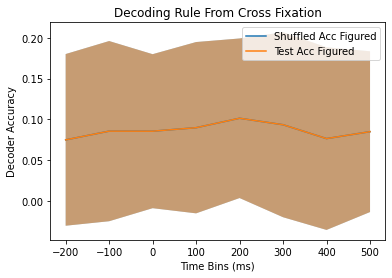

In [13]:
test_accs_figured = np.load(fs.open(f"l2l.pqz317.scratch/rule_accs_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy"))
shuffled_accs_figured = np.load(fs.open(f"l2l.pqz317.scratch/rule_shuffled_accs_figured_{pre_interval}_crossfix_{post_interval}_by_block_split.npy"))


# # generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs_figured,
    pre_interval, post_interval, 100,
    ax,
    label="Shuffled Acc Figured",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_figured,
    pre_interval, post_interval, 100,
    ax,
    label="Test Acc Figured",
    right_align=True
)
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Rule From Cross Fixation")
ax.legend()